In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

tf_keras = tf.keras

2024-12-02 09:56:21.917586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/vl/ffnrmcms5mx5g1pss893jh0r0000gn/T/ipykernel_38163/2518654375.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [2]:
import cv2
import os
import random
from tqdm import tqdm
import numpy as np
from collections import Counter

# Paths to the image folders
cat_folder = 'data/cat'
dog_folder = 'data/dog'

X_cat = []
y_cat = []
X_dog = []
y_dog = []

# Process the cat folder
if os.path.exists(cat_folder):
    for i in tqdm(os.listdir(cat_folder)):
        img_path = os.path.join(cat_folder, i)  # Construct full path
        img = cv2.imread(img_path)
        if img is not None:  # Check if the image was read successfully
            img = cv2.resize(img, (224, 224))
            X_cat.append(img)
            y_cat.append('Cat')  # Label as 'Cat' for all cat images
else:
    print(f"Folder not found: {cat_folder}")

# Process the dog folder
if os.path.exists(dog_folder):
    for i in tqdm(os.listdir(dog_folder)):
        img_path = os.path.join(dog_folder, i)  # Construct full path
        img = cv2.imread(img_path)
        if img is not None:  # Check if the image was read successfully
            img = cv2.resize(img, (224, 224))
            X_dog.append(img)
            y_dog.append('Dog')  # Label as 'Dog' for all dog images
else:
    print(f"Folder not found: {dog_folder}")
    
if len(X_cat) >= 100 and len(X_dog) >= 1000:
    cat_sample_indices = random.sample(range(len(X_cat)), 100)
    dog_sample_indices = random.sample(range(len(X_dog)), 1000)

    X_cat_sample = [X_cat[i] for i in cat_sample_indices]
    y_cat_sample = [y_cat[i] for i in cat_sample_indices]

    X_dog_sample = [X_dog[i] for i in dog_sample_indices]
    y_dog_sample = [y_dog[i] for i in dog_sample_indices]

    # Combine the sampled data
    X_sample = X_cat_sample + X_dog_sample
    y_sample = y_cat_sample + y_dog_sample

    print(f"Sampled {len(X_cat_sample)} cat images and {len(X_dog_sample)} dog images.")
else:
    print("Not enough images: need at least 3000 cats and 300 dogs.")


100%|██████████| 12513/12513 [00:32<00:00, 382.27it/s]

Sampled 100 cat images and 1000 dog images.


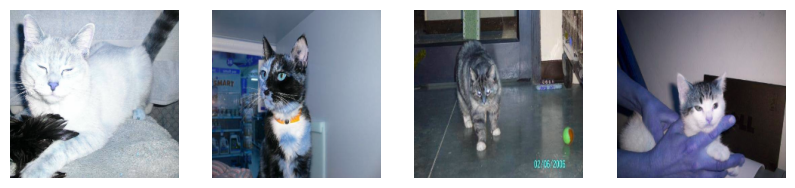

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_sample[i], cmap="gray")
    plt.axis('off')
plt.show()

In [4]:
print(f"Number of images in X: {len(X_sample)}")
print(f"Number of labels in y: {len(y_sample)}")
assert len(X_sample) == len(y_sample), "Mismatch between features and labels!"

Number of images in X: 1100
Number of labels in y: 1100


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [6]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test) 

In [7]:
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (770, 224, 224, 3)
X_test Shape:  (330, 224, 224, 3)
y_train Shape:  (770, 2)
y_test Shape:  (330, 2)


In [8]:
X_train_flattened = [x.flatten() for x in X_train]
X_test_flattened = [x.flatten() for x in X_test]

# Convert to numpy arrays for compatibility with Scikit-learn
X_train_flattened = np.array(X_train_flattened)
X_test_flattened = np.array(X_test_flattened)

# Check the shape
print("Shape of X_train after flattening:", X_train_flattened.shape)
print("Shape of X_test after flattening:", X_test_flattened.shape)

Shape of X_train after flattening: (770, 150528)
Shape of X_test after flattening: (330, 150528)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load the VGG16 model without the top layers
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the feature extractor model
feature_extractor = Model(inputs=vgg.input, outputs=GlobalAveragePooling2D()(vgg.output))

print(feature_extractor.summary())  # Optional: View the model structure



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# Assuming X is your list of images
X = np.array(X_sample) / 255.0  # Normalize pixel values

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load VGG16 without the top layers
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a model for feature extraction
feature_extractor = Model(inputs=vgg.input, outputs=GlobalAveragePooling2D()(vgg.output))


In [12]:
# Extract features from the dataset
X_features = feature_extractor.predict(X)

print(f"Extracted features shape: {X_features.shape}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step
Extracted features shape: (1100, 512)


In [13]:
y_sample = np.array([1 if label == 'Cat' else -1 for label in y_sample], dtype=np.int32)
print(f"Unique values in y_test_encoded after conversion: {set(y_sample)}")

Unique values in y_test_encoded after conversion: {1, -1}


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split features into train and test sets
X_train_features, X_test_features, y_train_encoded, y_test_encoded = train_test_split(
    X_features, y_sample, test_size=0.2, random_state=42
)


In [15]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Soft-margin SVM using CVXPY
def soft_margin_svm(X, y, C):
    """
    Solves the soft-margin SVM problem using CVXPY
    Args:
    - X: Data matrix of shape (m, n) where m is the number of points and n is the dimension (features).
    - y: Labels vector of shape (m,) with entries in {-1, 1}.
    - C: Regularization parameter.
    Returns:
    - b: Coefficient vector of shape (n,)
    - c: Intercept (scalar)
    - xi: Slack variables vector of shape (m,)
    """
    m, n = X.shape

    # Define the variables
    b = cp.Variable(n)    # weight vector
    c = cp.Variable()     # bias
    xi = cp.Variable(m)   # slack variables

    # Define the objective function: minimize (1/2) * ||b||^2 + C * sum(xi)
    objective = cp.Minimize(0.5 * cp.sum_squares(b) + C * cp.sum(xi))

    # Define the constraints: y_i * (b^T x_i + c) >= 1 - xi_i, xi_i >= 0
    constraints = [y[i] * (X[i] @ b + c) >= 1 - xi[i] for i in range(m)]
    constraints += [xi >= 0]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Return the solution: b, c, and xi
    return b.value, c.value, xi.value

# Function to predict using the learned SVM model
def predict(X, b, c):
    return np.sign(X @ b + c)


In [16]:
from sklearn.metrics import accuracy_score, classification_report
# Run the SVM (Soft-margin SVM)
C = 1.0  # Regularization parameter
b_opt, c_opt, xi_opt = soft_margin_svm(X_train_features, y_train_encoded, C)

# Predict the labels on the test set
y_pred_train = predict(X_train_features, b_opt, c_opt)

# Compute accuracy and display classification report
train_accuracy = accuracy_score(y_train_encoded, y_pred_train)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

print("Classification Report for Training Set:")
print(classification_report(y_train_encoded, y_pred_train))

Training Accuracy: 98.86%
Classification Report for Training Set:
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99       804
           1       1.00      0.87      0.93        76

    accuracy                           0.99       880
   macro avg       0.99      0.93      0.96       880
weighted avg       0.99      0.99      0.99       880



In [17]:
def USVM(A, B, n_universum, C=1.0, C_u=1.0, epsilon=0.1):
    """
    Universum SVM for any binary classification task.

    Args:
    - A: Matrix of points for class 1 (positive class).
    - B: Matrix of points for class -1 (negative class).
    - n_universum: Number of universum points to generate.
    - C: Regularization parameter for training data.
    - C_u: Regularization parameter for universum data.
    - epsilon: Margin for universum points.

    Returns:
    - b_opt: Optimal weight vector.
    - c_opt: Optimal bias term.
    - universum_points: Generated universum points.
    """

    n_class1, n_features = A.shape
    n_class_minus_1 = B.shape[0]

    # Generate Universum points by averaging randomly selected points from both classes
    random_indices_class_1 = np.random.choice(n_class1, n_universum, replace=True)
    random_indices_class_minus_1 = np.random.choice(n_class_minus_1, n_universum, replace=True)
    universum_points = (A[random_indices_class_1] + B[random_indices_class_minus_1]) / 2

    # Combine the classes into a single dataset
    X_train = np.vstack((A, B))
    y_train = np.hstack((np.ones(n_class1), -np.ones(n_class_minus_1)))

    # Variables for optimization
    b = cp.Variable(n_features)  # We use 'b' for the weight vector
    c = cp.Variable()
    xi = cp.Variable(n_class1 + n_class_minus_1)  # Slack variables for misclassification
    psi = cp.Variable(n_universum)  # Slack variables for universum points (positive side)
    phi = cp.Variable(n_universum)  # Slack variables for universum points (negative side)

    # Constraints
    constraints = []

    # For class 1 (label +1)
    for i in range(n_class1):
        constraints.append(A[i, :] @ b + c >= 1 - xi[i])

    # For class -1 (label -1)
    for i in range(n_class_minus_1):
        constraints.append(B[i, :] @ b + c <= -1 + xi[n_class1 + i])

    # Universum constraints
    for j in range(n_universum):
        constraints.append(universum_points[j, :] @ b + c <= epsilon + psi[j])
        constraints.append(universum_points[j, :] @ b + c >= -epsilon - phi[j])

    # Non-negative slack variables
    constraints += [xi >= 0, psi >= 0, phi >= 0]

    # Objective function: minimize the sum of errors and regularization term
    objective = cp.Minimize(0.5 * cp.norm(b, 2)**2 + C * cp.sum(xi) + C_u * (cp.sum(psi) + cp.sum(phi)))

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Get the optimal values of b and c
    b_opt = b.value
    c_opt = c.value

    return b_opt, c_opt, universum_points

def predict(X, b, c):
    """
    Predict the labels based on the decision boundary.

    Args:
    - X: Data points.
    - b: Optimal weight vector.
    - c: Optimal bias term.

    Returns:
    - Predictions (1 or -1).
    """
    return np.sign(X @ b + c)


In [19]:
from sklearn.metrics import classification_report

A = X_train_features[y_train_encoded == 1]  
B = X_train_features[y_train_encoded == -1]
n_universum = 900

# Run the Universum SVM
b_opt, c_opt, universum_points = USVM(A, B, n_universum, C =1, C_u =1, epsilon=0.1)


# Predict the labels based on the learned decision boundary
y_pred = predict(X_train_features, b_opt, c_opt)

# Compute the accuracy score
accuracy = accuracy_score(y_train_encoded, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_train_encoded, y_pred))

Accuracy: 99.32%
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.99      1.00       804
           1       0.93      1.00      0.96        76

    accuracy                           0.99       880
   macro avg       0.96      1.00      0.98       880
weighted avg       0.99      0.99      0.99       880



In [20]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

def tsvm(A, B, C1=1.0, C2=1.0):
    """
    TSVM

    Args:
    - A: Matrix of points for class 1 (positive class).
    - B: Matrix of points for class -1 (negative class).
    - n_universum: Number of Universum points to generate.
    - C1: Regularization parameter for class 1.
    - C2: Regularization parameter for class -1.

    Returns:
    - b1_opt, c1_opt: Optimal weight vector and bias for class 1 hyperplane.
    - b2_opt, c2_opt: Optimal weight vector and bias for class -1 hyperplane.
    """

    n_class1, n_features = A.shape
    n_class_minus_1 = B.shape[0]



    # Optimization variables for Class 1
    b1 = cp.Variable(n_features)
    c1 = cp.Variable()
    xi1 = cp.Variable(n_class_minus_1)  # Slack variables for class -1 constraints
    
    # Optimization variables for Class 2
    b2 = cp.Variable(n_features)
    c2 = cp.Variable()
    xi2 = cp.Variable(n_class1)  # Slack variables for class 1 constraints
  

    # Objective function for Class 1
    objective1 = cp.Minimize(0.5 * cp.norm(A @ b1 + c1, 2)**2 + C1 * cp.sum(xi1))

    # Constraints for Class 1
    constraints1 = [
        -B @ b1 - c1 + xi1 >= np.ones(n_class_minus_1),
        xi1 >= 0  # Class -1 points
    ]

    # Solve for Class 1
    problem1 = cp.Problem(objective1, constraints1)
    problem1.solve()
    b1_opt = b1.value
    c1_opt = c1.value

    # Objective function for Class 2
    objective2 = cp.Minimize(0.5 * cp.norm(B @ b2 + c2, 2)**2 + C2 * cp.sum(xi2))

    # Constraints for Class 2
    constraints2 = [
        A @ b2 + c2 + xi2 >= np.ones(n_class1),
        xi2 >= 0   # Class 1 points
    ]

    # Solve for Class 2
    problem2 = cp.Problem(objective2, constraints2)
    problem2.solve()
    b2_opt = b2.value
    c2_opt = c2.value

    return b1_opt, c1_opt, b2_opt, c2_opt

def predict(X, b1_opt, c1_opt, b2_opt, c2_opt):
    """
    Predicts the labels for the given data points using TSVM with learned hyperplanes.

    Args:
    - X: Input data points, shape (n_samples, n_features).
    - b1_opt: Optimal weight vector for class 1 hyperplane.
    - c1_opt: Optimal bias for class 1 hyperplane.
    - b2_opt: Optimal weight vector for class -1 hyperplane.
    - c2_opt: Optimal bias for class -1 hyperplane.

    Returns:
    - y_pred: Predicted labels for the data points, +1 or -1.
    """
    # Calculate distance from hyperplane 1 (class +1)
    distance_to_class1 = np.abs(np.dot(X, b1_opt) + c1_opt)
    
    # Calculate distance from hyperplane 2 (class -1)
    distance_to_class2 = np.abs(np.dot(X, b2_opt) + c2_opt)
    
    # Assign label based on which hyperplane is closer
    y_pred = np.where(distance_to_class1 < distance_to_class2, 1, -1)
    
    return y_pred

In [21]:
from sklearn.metrics import classification_report
np.random.seed(42)

A = X_train_features[y_train_encoded == 1]  
B = X_train_features[y_train_encoded == -1]

In [22]:
# TSVM
b1_opt, c1_opt, b2_opt, c2_opt  = tsvm(
    A, B, C1=1.0, C2=1.0)

# Predict on the train data
y_pred = predict(X_train_features, b1_opt, c1_opt, b2_opt, c2_opt)

# Calculate the accuracy
accuracy = accuracy_score(y_train_encoded, y_pred)

# Output the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_train_encoded, y_pred))

Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       804
           1       1.00      1.00      1.00        76

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880



In [23]:
from scipy.sparse import issparse
def UTSVM(X, y, n_universum=25, C1=1.0, C2=1.0, Cu=1.0, epsilon=0.1):
    """
    Universum Twin SVM.

    Args:
    - X: Training matrix
    - y: Labels vector
    - n_universum: Number of Universum points to generate.
    - C1: Regularization parameter for class 1.
    - C2: Regularization parameter for class -1.
    - Cu: Regularization parameter for Universum points.
    - epsilon: Margin for Universum points.

    Returns:
    - b1_opt, c1_opt: Optimal weight vector and bias for class 1 hyperplane.
    - b2_opt, c2_opt: Optimal weight vector and bias for class -1 hyperplane.
    """


    # A: Matrix of points for class 1 (positive class)
    #A = X[y==1]
    # B: Matrix of points for class -1 (negative class)
    #B = X[y==-1]

    n_class1, n_features = A.shape
    n_class_minus_1 = B.shape[0]


    # Generate Universum points by averaging randomly selected points from both classes
    random_indices_class_1 = np.random.choice(n_class1, n_universum, replace=True)
    random_indices_class_minus_1 = np.random.choice(n_class_minus_1, n_universum, replace=True)
    U = (A[random_indices_class_1] + B[random_indices_class_minus_1]) / 2

    # Optimization variables for Class 1
    b1 = cp.Variable(n_features)
    c1 = cp.Variable()
    xi1 = cp.Variable(n_class_minus_1)  # Slack variables for class -1 constraints
    psi1 = cp.Variable(n_universum)  # Slack variables for Universum points (class 1)

    # Optimization variables for Class 2
    b2 = cp.Variable(n_features)
    c2 = cp.Variable()
    xi2 = cp.Variable(n_class1)  # Slack variables for class 1 constraints
    psi2 = cp.Variable(n_universum)  # Slack variables for Universum points (class -1)

    # Objective function for Class 1
    objective1 = cp.Minimize(0.5 * cp.norm(A @ b1 + c1, 2)**2 + C1 * cp.sum(xi1) + Cu * cp.sum(psi1))

    # Constraints for Class 1
    constraints1 = [
        -B @ b1 - c1 + xi1 >= np.ones(n_class_minus_1),  # Class -1 points
        U @ b1 + c1 + psi1 >= (-1 + epsilon) * np.ones(n_universum),  # Universum points
        xi1 >= 0, psi1 >= 0  # Non-negative slack variables
    ]

    # Solve for Class 1
    problem1 = cp.Problem(objective1, constraints1)
    problem1.solve()
    b1_opt = b1.value
    c1_opt = c1.value

    # Objective function for Class 2
    objective2 = cp.Minimize(0.5 * cp.norm(B @ b2 + c2, 2)**2 + C2 * cp.sum(xi2) + Cu * cp.sum(psi2))

    # Constraints for Class 2
    constraints2 = [
        A @ b2 + c2 + xi2 >= np.ones(n_class1),  # Class 1 points
        -U @ b2 - c2 + psi2 >= (-1 + epsilon) * np.ones(n_universum),  # Universum points
        xi2 >= 0, psi2 >= 0  # Non-negative slack variables
    ]

    # Solve for Class 2
    problem2 = cp.Problem(objective2, constraints2)
    problem2.solve()
    b2_opt = b2.value
    c2_opt = c2.value

    return b1_opt, c1_opt, b2_opt, c2_opt, U

def predict(X, b1_opt, c1_opt, b2_opt, c2_opt):
    """
    Predicts the labels for the given data points using TSVM with learned hyperplanes.

    Args:
    - X: Input data points, shape (n_samples, n_features).
    - b1_opt: Optimal weight vector for class 1 hyperplane.
    - c1_opt: Optimal bias for class 1 hyperplane.
    - b2_opt: Optimal weight vector for class -1 hyperplane.
    - c2_opt: Optimal bias for class -1 hyperplane.

    Returns:
    - y_pred: Predicted labels for the data points, +1 or -1.
    """
    # Calculate distance from hyperplane 1 (class +1)
    distance_to_class1 = np.abs(np.dot(X, b1_opt) + c1_opt)
    
    # Calculate distance from hyperplane 2 (class -1)
    distance_to_class2 = np.abs(np.dot(X, b2_opt) + c2_opt)
    
    # Assign label based on which hyperplane is closer
    y_pred = np.where(distance_to_class1 < distance_to_class2, 1, -1)
    
    return y_pred




In [24]:
# UTSVM
n_universum=900

b1_opt, c1_opt, b2_opt, c2_opt, U  = UTSVM(
    A, B, n_universum, C1=1.0, C2=1.0, Cu=1.0)

# Predict on the train data
y_pred = predict(X_train_features, b1_opt, c1_opt, b2_opt, c2_opt)

# Calculate the accuracy
accuracy = accuracy_score(y_train_encoded, y_pred)

# Output the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_train_encoded, y_pred))

Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       804
           1       1.00      1.00      1.00        76

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880



In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin

class QSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, mu=0.2):
        self.mu = mu

    def fit(self, X, y):
        self.d = self._calculate_d(X.shape[1])  # Calculate dimensionality once
        G, r = self.compute_G_and_r(X)
        self.z, self.c = self.optimize_z_c(G, r, y, self.mu)
        return self  # Return self instead of z and c

    def predict(self, X):
        r = self._compute_r_matrix(X)
        return np.sign(r @ self.z + self.c)

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

    def compute_G_and_r(self, X):
        """Compute the matrices G and r based on X."""
        m, n = X.shape
        G = np.zeros((self.d, self.d))
        r = np.zeros((m, self.d))
        D_n = self.get_duplication_matrix(n)

        print("Start computing G and r...")
        for i in tqdm(range(m)):
            x_i = X[i, :]
            s_i = self._compute_s_i(x_i)
            r[i] = np.concatenate([s_i, x_i])
            X_i = np.kron(np.eye(n), x_i.reshape(1, -1))
            M_i = X_i @ D_n
            H_i = np.hstack([M_i, np.eye(n)])
            G += 2 * H_i.T @ H_i
        print("Finished computing G and r...\n")

        return G, r

    def loss(self, z, G, r, y, c, mu):
        square_loss = 0.5 * z.T @ G @ z
        y_hat = r @ z + c
        hinge_loss = np.sum(np.maximum(0, 1 - np.multiply(y, y_hat)))
        return square_loss + mu * hinge_loss

    def optimize_z_c(self, G, r, y, mu):
        d = G.shape[0]
        z = cp.Variable((d, 1))
        c = cp.Variable()
        y = np.array(y).reshape(-1, 1)

        square_loss = 0.5 * cp.quad_form(z, G)
        y_hat = r @ z + c
        hinge_loss = cp.sum(cp.maximum(0, 1 - cp.multiply(y, y_hat)))
        objective = cp.Minimize(square_loss + mu * hinge_loss)
        prob = cp.Problem(objective)
        result = prob.solve(solver=cp.CLARABEL, verbose=False)

        return z.value, c.value

    def _compute_r_matrix(self, X):
        """Helper to compute the r matrix for predictions."""
        m, n = X.shape
        r = np.zeros((m, self.d))
        for i in range(m):
            x_i = X[i, :]
            s_i = self._compute_s_i(x_i)
            r[i] = np.concatenate([s_i, x_i])
        return r

    def _compute_s_i(self, x_i):
        """Helper to compute s_i (half-vectorization) from x_i."""
        x_i_x_i_T = np.outer(x_i, x_i)
        return 0.5 * self.hvec(x_i_x_i_T)

    def hvec(self, A):
        """Half-vectorization of a symmetric matrix A."""
        indices = np.triu_indices(A.shape[0])
        return A[indices]

    def get_duplication_matrix(self, n):
        """Duplication matrix for vectorizing a symmetric matrix."""
        i_indices = np.arange(n*n)
        j_indices = np.zeros((n, n), dtype=int)

        z = 0
        for x in range(n):
            for y in range(x, n):
                j_indices[x, y] = j_indices[y, x] = z
                z += 1

        j_indices_flat = j_indices.flatten()
        data = np.ones(n*n, dtype=int)
        return coo_matrix((data, (i_indices, j_indices_flat)), shape=(n*n, (n*(n+1))//2))

    def _calculate_d(self, n):
        """Helper to calculate the dimensionality once."""
        return n + n * (n + 1) // 2


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Preprocess the data
# Normalize data (important for SVM)
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train_features)
X_test_standard = scaler_standard.transform(X_test_features)

pca = PCA()
X_pca = pca.fit_transform(X_train_standard)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
k = (cumulative_variance>=0.9).argmax()+1

pca= PCA(n_components=k)
X_train_reduced = pca.fit_transform(X_train_standard)
X_test_reduced = pca.transform(X_test_standard)

print(f"Training data shape: {X_train_reduced.shape}")
print(f"Test data shape: {X_test_reduced.shape}")

Training data shape: (880, 176)
Test data shape: (220, 176)


In [27]:
from scipy.sparse import coo_matrix
from tqdm import tqdm

qsvm = QSVM(mu = 2)
clf = qsvm.fit(X_train_reduced, y_train_encoded)

Start computing G and r...


100%|██████████| 880/880 [27:48<00:00,  1.90s/it]


Finished computing G and r...



In [28]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test data
y_pred = qsvm.predict(X_train_reduced)

# Calculate the accuracy
accuracy = accuracy_score(y_train_encoded, y_pred)

# Output the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_train_encoded, y_pred))

Accuracy: 99.09%
Classification Report:
              precision    recall  f1-score   support

          -1       0.99      1.00      1.00       804
           1       1.00      0.89      0.94        76

    accuracy                           0.99       880
   macro avg       1.00      0.95      0.97       880
weighted avg       0.99      0.99      0.99       880



In [29]:
class UQSVM:
    def __init__(self, C=1, C_u=1, epsilon=0.1, n_universum=10):

        """
        Universum Quadratic SVM for any binary classification task.
        Args:

        - C: Regularization parameter for training data.
        - C_u: Regularization parameter for universum data.
        - epsilon: Margin for universum points.
        - n_universum: Number of universum points to generate.
        """
        self.C = C
        self.C_u = C_u
        self.epsilon = epsilon
        self.n_universum = n_universum

    def fit(self, X, y):
        """
        Fit the U-QSVM model.

        X: Training data matrix.
        y: Labels corresponding to rows of X.
        """
        self.d = self._calculate_d(X.shape[1])  # Calculate dimensionality once

        # Separate positive and negative samples
        A = X[y == 1]
        B = X[y == -1]

        # Generate Universum points by averaging randomly selected points from both classes
        n_class1, n_features = A.shape
        n_class_minus_1 = B.shape[0]
        random_indices_class_1 = np.random.choice(n_class1, self.n_universum, replace=True)
        random_indices_class_minus_1 = np.random.choice(n_class_minus_1, self.n_universum, replace=True)
        U = (A[random_indices_class_1] + B[random_indices_class_minus_1]) / 2

        # Compute G, r, and r_u matrices
        G, r, r_u = self.compute_G_and_r_and_r_u(X, U)
        self.z, self.c = self.optimize_z_c(G, r, y, r_u)

        return self.z, self.c, U

    def predict(self, X):
        """
        Make predictions using the fitted U-QSVM model.

        X: Test data (features).
        """
        r = self._compute_r_matrix(X)
        return np.sign(r @ self.z + self.c)

    def score(self, X, y):
        """
        Calculate the accuracy of the U-QSVM model.

        X: Test data (features).
        y: True labels for the test data.
        """
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

    def compute_G_and_r_and_r_u(self, X, U):
        """Compute the matrices G, r, and r_u based on trainsing matrix X and Universum matrix U."""
        m, n = X.shape
        G = np.zeros((self.d, self.d))
        r = np.zeros((m, self.d))
        D_n = self.get_duplication_matrix(n)

        R, _ = U.shape
        r_u = np.zeros((R, self.d))

        print("Start computing G and r...")
        for i in tqdm(range(m)):
            x_i = X[i, :]
            s_i = self._compute_s_i(x_i)
            r[i] = np.concatenate([s_i, x_i])
            X_i = np.kron(np.eye(n), x_i.reshape(1, -1))
            M_i = X_i @ D_n
            H_i = np.hstack([M_i, np.eye(n)])
            G += 2 * H_i.T @ H_i
        print("Finished computing G and r...")

        print("Start computing r_u...")
        for i in tqdm(range(R)):
            u_i = U[i, :]
            s_u_i = self._compute_s_i(u_i)
            r_u[i] = np.concatenate([s_u_i, u_i])
        print("Finished computing r_u...")

        return G, r, r_u

    def loss(self, z, G, r, y, c, r_u):
        """Compute the objective function for the U-QSVM model."""
        square_loss = 0.5 * z.T @ G @ z
        hinge_loss = np.sum(np.maximum(0, 1 - np.multiply(y, r @ z + c)))
        hinge_loss_Universum_1 = np.sum(np.maximum(0,  - self.epsilon + (r_u @ z + c)))
        hinge_loss_Universum_2 = np.sum(np.maximum(0,  - self.epsilon - (r_u @ z + c)))
        return square_loss + self.C * hinge_loss + self.C_u * (hinge_loss_Universum_1 + hinge_loss_Universum_2)

    def optimize_z_c(self, G, r, y, r_u):
        """Optimize the parameters z and c using convex programming."""
        d = G.shape[0]
        z = cp.Variable((d, 1))
        c = cp.Variable()
        y = np.array(y).reshape(-1, 1)

        square_loss = 0.5 * cp.quad_form(z, G)
        hinge_loss = cp.sum(cp.maximum(0, 1 - cp.multiply(y, r @ z + c)))
        hinge_loss_Universum_1 = cp.sum(cp.maximum(0,  - self.epsilon - (r_u @ z + c)))
        hinge_loss_Universum_2 = cp.sum(cp.maximum(0,  - self.epsilon + (r_u @ z + c)))
        objective = cp.Minimize(square_loss + self.C * hinge_loss + self.C_u * (hinge_loss_Universum_1 + hinge_loss_Universum_2))
        prob = cp.Problem(objective)
        result = prob.solve(solver=cp.SCS, verbose=False)  # Change solver if needed

        return z.value, c.value

    def _compute_r_matrix(self, X):
        """Helper to compute the r matrix for predictions."""
        m, n = X.shape
        r = np.zeros((m, self.d))
        for i in range(m):
            x_i = X[i, :]
            s_i = self._compute_s_i(x_i)
            r[i] = np.concatenate([s_i, x_i])
        return r

    def _compute_s_i(self, x_i):
        """Helper to compute s_i (half-vectorization) from x_i."""
        x_i_x_i_T = np.outer(x_i, x_i)
        return 0.5 * self.hvec(x_i_x_i_T)

    def hvec(self, A):
        """Half-vectorization of a symmetric matrix A."""
        indices = np.triu_indices(A.shape[0])
        return A[indices]

    def get_duplication_matrix(self, n):
        """Duplication matrix for vectorizing a symmetric matrix."""
        i_indices = np.arange(n * n)
        j_indices = np.zeros((n, n), dtype=int)

        z = 0
        for x in range(n):
            for y in range(x, n):
                j_indices[x, y] = j_indices[y, x] = z
                z += 1

        j_indices_flat = j_indices.flatten()
        data = np.ones(n * n, dtype=int)
        return coo_matrix((data, (i_indices, j_indices_flat)), shape=(n * n, (n * (n + 1)) // 2))

    def _calculate_d(self, n):
        """Helper to calculate the dimensionality once."""
        return n + n * (n + 1) // 2


In [30]:
uqsvm = UQSVM(C=1.0, C_u=0.5, epsilon=0.3, n_universum=900)
clf = uqsvm.fit(X_train_reduced, y_train_encoded)

Start computing G and r...


100%|██████████| 880/880 [39:50<00:00,  2.72s/it]  


Finished computing G and r...
Start computing r_u...


100%|██████████| 900/900 [00:00<00:00, 2535.52it/s]


Finished computing r_u...


In [31]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test data
y_pred = uqsvm.predict(X_train_reduced)

# Calculate the accuracy
accuracy = accuracy_score(y_train_encoded, y_pred)

# Output the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_train_encoded, y_pred))

Accuracy: 99.20%
Classification Report:
              precision    recall  f1-score   support

          -1       0.99      1.00      1.00       804
           1       1.00      0.91      0.95        76

    accuracy                           0.99       880
   macro avg       1.00      0.95      0.97       880
weighted avg       0.99      0.99      0.99       880



In [32]:
class QTSVM:
    def __init__(self, C_1=1, C_2=1):

        """
        Imbalanced Universum Quadratic Twin SVM for any binary classification task.
        For each class, this model finds a quadratic function that passes through that class
        but makes sure the other class stay away one unit! Universum points are generated
        depending on the class that we are handling.

        Args:
        - C_1: Regularization parameter for class 1 points.
        - C_2: Regularization parameter for class -1 points.
        """

        self.C_1 = C_1
        self.C_2 = C_2

    def fit(self, X, y):
        """
        Fit the ImUQTSVM model.

        X: Training data matrix.
        y: Labels corresponding to rows of X.
        """
        self.d = self._calculate_d(X.shape[1])  # Calculate dimensionality once

        # Separate positive and negative samples
        A = X[y == 1]
        B = X[y == -1]

        # Undersample class -1 to construct a reduced majority matrix
        m_1 = A.shape[0]
        B_reduced_indices = np.random.choice(B.shape[0], m_1, replace=False)
        B_reduced = B[B_reduced_indices]

        m_2 = B.shape[0]
        r = m_2 - m_1
        # Create A_bar: Randomly choose rows from A with replacement
        A_bar_indices = np.random.choice(m_1, r, replace=True)
        A_bar = A[A_bar_indices]

        # Create B_bar: Randomly choose rows from B without replacement
        B_bar_indices = np.random.choice(m_2, r, replace=False)
        B_bar = B[B_bar_indices]

        # Compute r matrices
        r_1 = self.compute_r(A)
        r_2 = self.compute_r(B)
        r_2_reduced = self.compute_r(B_reduced)


        self.z_1, self.c_1 = self.optimize_z_1_c_1(r_1, r_2_reduced)
        self.z_2, self.c_2 = self.optimize_z_2_c_2(r_2, r_1)

        return self.z_1, self.c_1, self.z_2, self.c_2

    def predict(self, X, z_1, c_1, z_2, c_2):
        """
        Make predictions using the fitted UQTSVM model.
        X: Test data (features).
        """
        y_hat = np.ones(X.shape[0])
        for i in range(X.shape[0]):
            r_i = self.compute_r(X[i,:].reshape(1,-1))
            H_i = self.compute_H(X[i,:])

            numerator_1 = np.abs(r_i @ z_1 + c_1)
            denominator_1 = np.linalg.norm(H_i @ z_1 + c_1) ** 2
            numerator_2 = np.abs(r_i @ z_2 + c_2)
            denominator_2 = np.linalg.norm(H_i @ z_2 + c_2) ** 2

            expression_1 = numerator_1 / denominator_1
            expression_2 = numerator_2 / denominator_2

            if expression_1 >= expression_2:
                y_hat[i] = -1

        return y_hat

    def score(self, X, y):
        """
        Calculate the accuracy of the U-QSVM model.

        X: Test data (features).
        y: True labels for the test data.
        """
        #predictions = self.predict(X, z_1, c_1, z_2, c_2)
        predictions = self.predict(X, self.z_1, self.c_1, self.z_2, self.c_2)

        return accuracy_score(y, predictions)


    def compute_H(self, x):
      n = x.shape[0]
      s_x = self.compute_s_i(x)
      r_x = np.concatenate([s_x, x])
      X_x = np.kron(np.eye(n), x.reshape(1, -1))
      D_n = self.get_duplication_matrix(n)
      M_x = X_x @ D_n
      H_x = np.hstack([M_x, np.eye(n)])
      return H_x


    def optimize_z_1_c_1(self, r_1, r_2):

        d = r_1.shape[1]
        z_1 = cp.Variable((d, 1))
        c_1 = cp.Variable()

        # Square loss for regression points
        square_loss_1 = cp.sum_squares(r_1 @ z_1 + c_1)

        # Slack variables for errors in class 2 and Universum
        slack_class_2 = cp.Variable((r_2.shape[0], 1), nonneg=True)

        # slack_class_2 = cp.Variable(r_2.shape[0], nonneg=True)
        # slack_universum = cp.Variable(r_u.shape[0], nonneg=True)

        # Constraints
        constraints = []

        # Ensure all points in class 2 satisfy the margin or account for errors
        constraints.append(r_2 @ z_1 + c_1 <= -1 + slack_class_2)

        # Objective: Minimize square loss + hinge penalties for class 2 and Universum
        objective = cp.Minimize(
            square_loss_1
            + self.C_1 * cp.sum(slack_class_2)
        )

        # Problem definition
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS, verbose=False)  # Use any preferred solver

        return z_1.value, c_1.value


    def optimize_z_2_c_2(self, r_2, r_1):

        d = r_2.shape[1]
        z_2 = cp.Variable((d, 1))
        c_2 = cp.Variable()

        # Square loss for class 1 points
        square_loss_1 = cp.sum_squares(r_2 @ z_2 + c_2)

        # Slack variables for errors in class 1 and Universum
        slack_class_1 = cp.Variable((r_1.shape[0], 1), nonneg=True)

        # slack_class_1 = cp.Variable(r_1.shape[0], nonneg=True)
        # slack_universum = cp.Variable(r_u.shape[0], nonneg=True)

        # Constraints
        constraints = []

        # Ensure all points in class 1 satisfy the margin or account for errors
        constraints.append(r_1 @ z_2 + c_2 >= 1 - slack_class_1)


        # Objective: Minimize square loss + hinge penalties for class 1 and Universum
        objective = cp.Minimize(
            square_loss_1
            + self.C_2 * cp.sum(slack_class_1)
        )

        # Problem definition
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS, verbose=False)  # Use any preferred solver

        return z_2.value, c_2.value

    def compute_r(self, X):
        """Helper to compute the r matrix for predictions."""
        m, n = X.shape
        r = np.zeros((m, self.d))
        for i in range(m):
            x_i = X[i, :]
            s_i = self.compute_s_i(x_i)
            r[i] = np.concatenate([s_i, x_i])
        return r

    def compute_s_i(self, x_i):
        """Helper to compute s_i (half-vectorization) from x_i."""
        x_i_x_i_T = np.outer(x_i, x_i)
        return 0.5 * self.hvec(x_i_x_i_T)

    def hvec(self, A):
        """Half-vectorization of a symmetric matrix A."""
        indices = np.triu_indices(A.shape[0])
        return A[indices]

    def get_duplication_matrix(self, n):
        """Duplication matrix for vectorizing a symmetric matrix."""
        i_indices = np.arange(n * n)
        j_indices = np.zeros((n, n), dtype=int)

        z = 0
        for x in range(n):
            for y in range(x, n):
                j_indices[x, y] = j_indices[y, x] = z
                z += 1

        j_indices_flat = j_indices.flatten()
        data = np.ones(n * n, dtype=int)
        return coo_matrix((data, (i_indices, j_indices_flat)), shape=(n * n, (n * (n + 1)) // 2))

    def _calculate_d(self, n):
        """Helper to calculate the dimensionality once."""
        return n + n * (n + 1) // 2


In [33]:
np.random.seed(42)

C_1 = 1
C_2 = 1

# Step 2: Initialize and train the UQTSVM model (Assuming the class UQTSVM is already defined)
qtsvm = QTSVM(C_1 = C_1, C_2 = C_2)
z_1, c_1, z_2, c_2 = qtsvm.fit(X_train_reduced, y_train_encoded)

In [34]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test data
y_pred = qtsvm.predict(X_train_reduced, z_1, c_1, z_2, c_2)

# Calculate the accuracy
accuracy = accuracy_score(y_train_encoded, y_pred)

# Output the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_train_encoded, y_pred))

Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       804
           1       1.00      1.00      1.00        76

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880



In [35]:
import math

class UQTSVM:
    def __init__(self, C_1=1, C_2=1, C_u=1, epsilon=0.15):

        """
        Imbalanced Universum Quadratic Twin SVM for any binary classification task.
        For each class, this model finds a quadratic function that passes through that class
        but makes sure the other class stay away one unit! Universum points are generated
        depending on the class that we are handling.

        Args:
        - C_1: Regularization parameter for class 1 points.
        - C_2: Regularization parameter for class -1 points.
        - C_u: Regularization parameter for Universum data.
        - epsilon: Margin for universum points.
        """

        self.C_1 = C_1
        self.C_2 = C_2
        self.C_u = C_u
        self.epsilon = epsilon

    def fit(self, X, y, n_universum=1289):
        """
        Fit the ImUQTSVM model.

        X: Training data matrix.
        y: Labels corresponding to rows of X.
        """
        self.d = self._calculate_d(X.shape[1])  # Calculate dimensionality once

        # Separate positive and negative samples
        A = X[y == 1]
        B = X[y == -1]

        # Undersample class -1 to construct a reduced majority matrix
        m_1 = A.shape[0]
        B_reduced_indices = np.random.choice(B.shape[0], m_1, replace=False)
        B_reduced = B[B_reduced_indices]

        m_2 = B.shape[0]
        r = m_2 - m_1
        # Create A_bar: Randomly choose rows from A with replacement
        A_bar_indices = np.random.choice(m_1, r, replace=True)
        A_bar = A[A_bar_indices]

        # Create B_bar: Randomly choose rows from B without replacement
        B_bar_indices = np.random.choice(m_2, r, replace=False)
        B_bar = B[B_bar_indices]

        # Generate Universum points
        U = (A_bar + B_bar) / 2  # Initial Universum points
        g = math.ceil(m_1 // 2)  # Reduced Universum size for class 1
        U_reduced = U[np.random.choice(U.shape[0], g, replace=True)]

        # Compute r matrices
        r_1 = self.compute_r(A)
        r_2 = self.compute_r(B)
        r_2_reduced = self.compute_r(B_reduced)
        r_u_full = self.compute_r(U)
        r_u_reduced = self.compute_r(U_reduced)


        self.z_1, self.c_1 = self.optimize_z_1_c_1(r_1, r_u_reduced, r_2_reduced)
        self.z_2, self.c_2 = self.optimize_z_2_c_2(r_2, r_u_full, r_1)

        return self.z_1, self.c_1, self.z_2, self.c_2, U

    def predict(self, X, z_1, c_1, z_2, c_2):
        """
        Make predictions using the fitted UQTSVM model.
        X: Test data (features).
        """
        y_hat = np.ones(X.shape[0])
        for i in range(X.shape[0]):
            r_i = self.compute_r(X[i,:].reshape(1,-1))
            H_i = self.compute_H(X[i,:])

            numerator_1 = np.abs(r_i @ z_1 + c_1)
            denominator_1 = np.linalg.norm(H_i @ z_1 + c_1) ** 2
            numerator_2 = np.abs(r_i @ z_2 + c_2)
            denominator_2 = np.linalg.norm(H_i @ z_2 + c_2) ** 2

            expression_1 = numerator_1 / denominator_1
            expression_2 = numerator_2 / denominator_2

            if expression_1 >= expression_2:
                y_hat[i] = -1

        return y_hat

    def score(self, X, y):
        """
        Calculate the accuracy of the U-QSVM model.

        X: Test data (features).
        y: True labels for the test data.
        """
        #predictions = self.predict(X, z_1, c_1, z_2, c_2)
        predictions = self.predict(X, self.z_1, self.c_1, self.z_2, self.c_2)

        return accuracy_score(y, predictions)


    def compute_H(self, x):
      n = x.shape[0]
      s_x = self.compute_s_i(x)
      r_x = np.concatenate([s_x, x])
      X_x = np.kron(np.eye(n), x.reshape(1, -1))
      D_n = self.get_duplication_matrix(n)
      M_x = X_x @ D_n
      H_x = np.hstack([M_x, np.eye(n)])
      return H_x


    def optimize_z_1_c_1(self, r_1, r_u, r_2):

        d = r_1.shape[1]
        z_1 = cp.Variable((d, 1))
        c_1 = cp.Variable()

        # Square loss for regression points
        square_loss_1 = cp.sum_squares(r_1 @ z_1 + c_1)

        # Slack variables for errors in class 2 and Universum
        slack_class_2 = cp.Variable((r_2.shape[0], 1), nonneg=True)
        slack_universum = cp.Variable((r_u.shape[0], 1), nonneg=True)

        # slack_class_2 = cp.Variable(r_2.shape[0], nonneg=True)
        # slack_universum = cp.Variable(r_u.shape[0], nonneg=True)

        # Constraints
        constraints = []

        # Ensure all points in class 2 satisfy the margin or account for errors
        constraints.append(r_2 @ z_1 + c_1 <= -1 + slack_class_2)

        # Ensure all Universum points satisfy the margin with epsilon tolerance
        constraints.append(r_u @ z_1 + c_1 >= -1 + self.epsilon - slack_universum)

        # Objective: Minimize square loss + hinge penalties for class 2 and Universum
        objective = cp.Minimize(
            square_loss_1
            + C_1 * cp.sum(slack_class_2)
            + C_u * cp.sum(slack_universum)
        )

        # Problem definition
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS, verbose=False)  # Use any preferred solver

        return z_1.value, c_1.value


    def optimize_z_2_c_2(self, r_2, r_u, r_1):

        d = r_2.shape[1]
        z_2 = cp.Variable((d, 1))
        c_2 = cp.Variable()

        # Square loss for class 1 points
        square_loss_1 = cp.sum_squares(r_2 @ z_2 + c_2)

        # Slack variables for errors in class 1 and Universum
        slack_class_1 = cp.Variable((r_1.shape[0], 1), nonneg=True)
        slack_universum = cp.Variable((r_u.shape[0], 1), nonneg=True)

        # slack_class_1 = cp.Variable(r_1.shape[0], nonneg=True)
        # slack_universum = cp.Variable(r_u.shape[0], nonneg=True)

        # Constraints
        constraints = []

        # Ensure all points in class 1 satisfy the margin or account for errors
        constraints.append(r_1 @ z_2 + c_2 >= 1 - slack_class_1)

        # Ensure all Universum points satisfy the margin with epsilon tolerance
        constraints.append(r_u @ z_2 + c_2 >= 1 - self.epsilon - slack_universum)

        # Objective: Minimize square loss + hinge penalties for class 1 and Universum
        objective = cp.Minimize(
            square_loss_1
            + C_2 * cp.sum(slack_class_1)
            + C_u * cp.sum(slack_universum)
        )

        # Problem definition
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS, verbose=False)  # Use any preferred solver

        return z_2.value, c_2.value

    def compute_r(self, X):
        """Helper to compute the r matrix for predictions."""
        m, n = X.shape
        r = np.zeros((m, self.d))
        for i in range(m):
            x_i = X[i, :]
            s_i = self.compute_s_i(x_i)
            r[i] = np.concatenate([s_i, x_i])
        return r

    def compute_s_i(self, x_i):
        """Helper to compute s_i (half-vectorization) from x_i."""
        x_i_x_i_T = np.outer(x_i, x_i)
        return 0.5 * self.hvec(x_i_x_i_T)

    def hvec(self, A):
        """Half-vectorization of a symmetric matrix A."""
        indices = np.triu_indices(A.shape[0])
        return A[indices]

    def get_duplication_matrix(self, n):
        """Duplication matrix for vectorizing a symmetric matrix."""
        i_indices = np.arange(n * n)
        j_indices = np.zeros((n, n), dtype=int)

        z = 0
        for x in range(n):
            for y in range(x, n):
                j_indices[x, y] = j_indices[y, x] = z
                z += 1

        j_indices_flat = j_indices.flatten()
        data = np.ones(n * n, dtype=int)
        return coo_matrix((data, (i_indices, j_indices_flat)), shape=(n * n, (n * (n + 1)) // 2))

    def _calculate_d(self, n):
        """Helper to calculate the dimensionality once."""
        return n + n * (n + 1) // 2


In [36]:
C_1 = 1
C_2 = 1
C_u = 0.5
epsilon = 0.1
n_universum = 900

uqtsvm = UQTSVM(C_1 = C_1, C_2 = C_2, C_u = C_u, epsilon = epsilon)
z_1, c_1, z_2, c_2, U = uqtsvm.fit(X_train_reduced, y_train_encoded, n_universum=900)

In [37]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test data
y_pred = uqtsvm.predict(X_train_reduced, z_1, c_1, z_2, c_2)

# Calculate the accuracy
accuracy = accuracy_score(y_train_encoded, y_pred)

# Output the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_train_encoded, y_pred))

Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       804
           1       1.00      1.00      1.00        76

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880

